In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [9]:
dfp = pd.read_csv('/content/covid_cities_features.csv')
dfp.head()


,city,state,total_cases,mean_cases,std_cases,total_deaths,mean_deaths,std_deaths,days_recorded,death_rate,mean_daily_growth,days_until_first_case
0,Abadia de Goiás,GO,1351.0,558.153664,426.181817,28,7.565012,7.530658,423,0.020725,3.193853,55
1,Abadia dos Dourados,MG,375.0,118.761229,119.465862,14,2.687943,4.138253,423,0.037333,0.886525,42
2,Abadiânia,GO,400.0,147.659574,105.898626,27,10.801418,8.029761,423,0.067500,0.945626,63
3,Abaetetuba,PA,7659.0,3646.444444,2098.725146,210,104.628842,48.581654,423,0.027419,18.106383,4
4,Abaeté,MG,1019.0,248.574468,312.806079,26,5.224586,6.855251,423,0.025515,2.408983,16


Foi decidido remover a feature "city", pois o intuito era analisar os casos de modo "macro", observando como os estados se organizariam ao final - se ficariam distribuidos de acordo com as regiões por exemplo.

In [10]:
columns_to_drop = ["city"]

df = dfp.drop(columns=columns_to_drop)

print("Nova forma:", df.shape)
df.info()
df.head()

Nova forma: (5570, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   state                  5570 non-null   object 
 1   total_cases            5570 non-null   float64
 2   mean_cases             5570 non-null   float64
 3   std_cases              5570 non-null   float64
 4   total_deaths           5570 non-null   int64  
 5   mean_deaths            5570 non-null   float64
 6   std_deaths             5570 non-null   float64
 7   days_recorded          5570 non-null   int64  
 8   death_rate             5570 non-null   float64
 9   mean_daily_growth      5570 non-null   float64
 10  days_until_first_case  5570 non-null   int64  
dtypes: float64(7), int64(3), object(1)
memory usage: 478.8+ KB


,state,total_cases,mean_cases,std_cases,total_deaths,mean_deaths,std_deaths,days_recorded,death_rate,mean_daily_growth,days_until_first_case
0,GO,1351.0,558.153664,426.181817,28,7.565012,7.530658,423,0.020725,3.193853,55
1,MG,375.0,118.761229,119.465862,14,2.687943,4.138253,423,0.037333,0.886525,42
2,GO,400.0,147.659574,105.898626,27,10.801418,8.029761,423,0.067500,0.945626,63
3,PA,7659.0,3646.444444,2098.725146,210,104.628842,48.581654,423,0.027419,18.106383,4
4,MG,1019.0,248.574468,312.806079,26,5.224586,6.855251,423,0.025515,2.408983,16


Depois de removido o nome das cidades, precisou-se transformar os dados qualitativos nominais da coluna em numéricos para poder usá-los. Para fazer isso, foi decidido usar o one hot encoding:

In [11]:
df['state'] = (
    df['state']
    .astype(str)          # garante string
    .str.strip()          # remove espaços
    .str.upper()          # padroniza
    .fillna('UNKNOWN')    # evita NaN
)
ohe = OneHotEncoder(sparse_output=False)

X_encoded = ohe.fit_transform(df[['state']])

X_encoded_df = pd.DataFrame(
    X_encoded,
    columns=ohe.get_feature_names_out(['state']),
    index=df.index
)

df_final = pd.concat(
    [df.drop('state', axis=1), X_encoded_df],
    axis=1
)

df_final.head()


,total_cases,mean_cases,std_cases,total_deaths,mean_deaths,std_deaths,days_recorded,death_rate,mean_daily_growth,days_until_first_case,...,state_PR,state_RJ,state_RN,state_RO,state_RR,state_RS,state_SC,state_SE,state_SP,state_TO
0,1351.0,558.153664,426.181817,28,7.565012,7.530658,423,0.020725,3.193853,55,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,375.0,118.761229,119.465862,14,2.687943,4.138253,423,0.037333,0.886525,42,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,400.0,147.659574,105.898626,27,10.801418,8.029761,423,0.067500,0.945626,63,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7659.0,3646.444444,2098.725146,210,104.628842,48.581654,423,0.027419,18.106383,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1019.0,248.574468,312.806079,26,5.224586,6.855251,423,0.025515,2.408983,16,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Como PCA é um algoritmo sensível à escala, faz-se necessário normalizar os dados antes de aplicar o código. Portanto, foi escolhido o min-máx por padronizar tipo em um intervalo entre 0 e 1:

In [12]:
X = df_final.values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

Aplicação do PCA da biblioteca do sklearn e plotagem do gráfico:

In [17]:
pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(X_scaled)
print("Número de componentes escolhidos automaticamente:", pca.n_components_)
print("Variância explicada acumulada:", pca.explained_variance_ratio_.cumsum())


print("Variância explicada por componente:")
print(pca.explained_variance_ratio_)


Número de componentes escolhidos automaticamente: 17
Variância explicada acumulada: [0.15016302 0.26310287 0.35225094 0.42962602 0.4956763  0.54858959
 0.5942759  0.63671205 0.67844119 0.71656072 0.75155837 0.78413873
 0.81317188 0.84058445 0.86712875 0.88775538 0.90632572]
Variância explicada por componente:
[0.15016302 0.11293985 0.08914807 0.07737508 0.06605029 0.05291328
 0.04568631 0.04243614 0.04172915 0.03811952 0.03499765 0.03258036
 0.02903315 0.02741257 0.0265443  0.02062663 0.01857034]


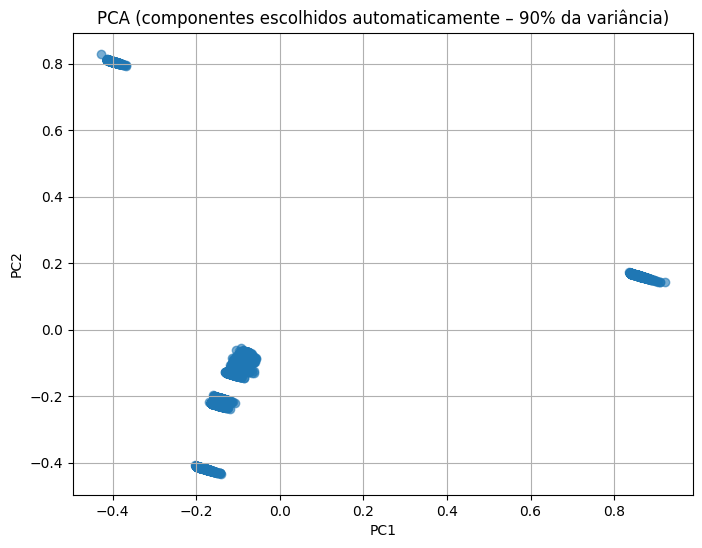

In [18]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA (componentes escolhidos automaticamente – 90% da variância)')
plt.grid(True)
plt.show()


Análise de cada componente principal escolhido pelo PCA

In [19]:
loadings = pd.DataFrame(
    pca.components_.T,
    index=df_final.columns,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)]
)

loadings['PC1'].abs().sort_values(ascending=False).head(10)

,PC1
state_MG,0.924417
state_SP,0.326522
state_RS,0.114035
days_until_first_case,0.081518
state_BA,0.079342
state_PR,0.070668
state_SC,0.043097
state_GO,0.030561
state_MA,0.028121
state_PB,0.028034


In [20]:
loadings['PC2'].abs().sort_values(ascending=False).head(10)


,PC2
state_SP,0.873476
state_RS,0.348876
state_MG,0.231882
state_BA,0.158548
state_PR,0.139113
state_SC,0.066198
state_GO,0.048702
state_PI,0.041468
state_PB,0.040621
state_MA,0.038251


Aplicação do K-means

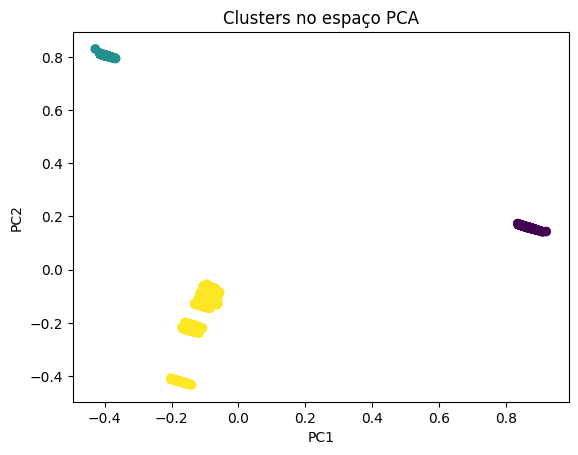

In [21]:
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_pca)

plt.scatter(X_pca[:,0], X_pca[:,1], c=labels)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters no espaço PCA')
plt.show()